<a href="https://colab.research.google.com/github/sourabhhegde/mahalnobis/blob/main/Sourabh_241058025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outlier Detection in ICU Patient Data Using Stratified Mahalanobis Distance

## 1. Introduction
The detection of clinical outliers is a crucial task in healthcare analytics, particularly in identifying patients at higher risk of adverse outcomes. In this study, we utilize Mahalanobis distance to identify outliers in a medical dataset containing patient records from an intensive care unit (ICU). Given that physiological and lab parameters vary across gender, we implement a stratified approach to ensure fairness and statistical rigor.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/AAPS/ICU_filtered.csv',index_col='recordid')

## 2. Dataset Overview
The dataset includes 7,886 patient records with both continuous and categorical features. Key columns include vitals, lab tests, gender, ICU admission types, and the target variable `In-hospital_death'

In [ ]:
data.shape

(7886, 35)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7886 entries, 132539 to 152864
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Length_of_stay     7886 non-null   int64  
 1   In-hospital_death  7886 non-null   int64  
 2   Age                7886 non-null   int64  
 3   Gender             7878 non-null   float64
 4   Height             4139 non-null   float64
 5   CCU                7886 non-null   int64  
 6   CSRU               7886 non-null   int64  
 7   SICU               7886 non-null   int64  
 8   DiasABP_first      5509 non-null   float64
 9   GCS_first          7768 non-null   float64
 10  Glucose_first      7786 non-null   float64
 11  HR_first           7768 non-null   float64
 12  MAP_first          5532 non-null   float64
 13  NIDiasABP_first    6905 non-null   float64
 14  NIMAP_first        6902 non-null   float64
 15  NISysABP_first     6910 non-null   float64
 16  Temp_first         776

In [ ]:
data.head(10)

,Length_of_stay,In-hospital_death,Age,Gender,Height,CCU,CSRU,SICU,DiasABP_first,GCS_first,...,Na_first,PaCO2_first,PaO2_first,Platelets_first,SysABP_first,WBC_first,Weight,pH_first,MechVent,UrineOutputSum
recordid,,,,,,,,,,,,,,,,,,,,,
132539,5,0,54,0.0,NaN,0,0,1,NaN,15.0,...,137.0,NaN,NaN,221.0,NaN,11.2,NaN,NaN,0,NaN
132540,8,0,76,1.0,175.3,0,1,0,67.0,3.0,...,139.0,34.0,344.0,164.0,105.0,7.4,80.6,7.45,1,5.0
132541,19,0,44,0.0,NaN,0,0,0,81.0,7.0,...,137.0,37.0,65.0,72.0,148.0,4.2,56.7,7.51,1,14.0
132543,9,0,68,1.0,180.3,0,0,0,NaN,15.0,...,140.0,NaN,NaN,391.0,NaN,11.5,84.6,NaN,0,NaN
132545,4,0,88,0.0,NaN,0,0,0,NaN,15.0,...,140.0,NaN,NaN,109.0,NaN,3.8,NaN,NaN,0,NaN
132547,6,0,64,1.0,180.3,1,0,0,79.0,7.0,...,141.0,45.0,78.0,276.0,150.0,24.0,NaN,7.29,1,12.0
132548,9,0,68,0.0,162.6,0,0,0,98.0,15.0,...,140.0,NaN,NaN,325.0,205.0,6.2,87.0,NaN,0,NaN
132551,6,1,78,0.0,162.6,0,0,0,50.0,15.0,...,141.0,30.0,128.0,91.0,103.0,16.1,48.4,7.40,1,12.0
132554,17,0,64,0.0,NaN,0,0,0,NaN,15.0,...,139.0,NaN,NaN,696.0,NaN,15.2,60.7,NaN,0,NaN


## 3. Preprocessing Pipeline

- Columns with >50% missing data were dropped.
- Categorical columns (`Gender`, `CCU`, `CSRU`, `SICU`, `MechVent`) were imputed with mode and cast to `category` dtype.
- Continuous columns were standardized using `StandardScaler`.
- Missing values in continuous features were imputed using `KNNImputer`.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

def preprocess_medical_data(df, target='In-hospital_death'):
    df = df.copy()

    # Step 0: Drop columns with more than 50% missing data
    df = df.loc[:, df.isnull().mean() < 0.5]

    # Step 1: Define categorical columns
    categorical_cols = ['Gender', 'CCU', 'CSRU', 'SICU', 'MechVent']
    categorical_cols = [col for col in categorical_cols if col in df.columns]

    # Step 2: Fill missing values in categorical columns with mode
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
        df[col] = df[col].astype('category')

    # Step 3: Identify numeric columns excluding target and categorical ones
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in categorical_cols and col != target]

    # Step 4: Standardize numeric data
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df[numeric_cols]),
        columns=numeric_cols,
        index=df.index
    )

    # Step 5: Impute missing values using KNN
    imputer = KNNImputer(n_neighbors=5)
    df_imputed_scaled = pd.DataFrame(
        imputer.fit_transform(df_scaled),
        columns=numeric_cols,
        index=df.index
    )

    # Step 6: Inverse transform to original scale
    df_imputed = pd.DataFrame(
        scaler.inverse_transform(df_imputed_scaled),
        columns=numeric_cols,
        index=df.index
    )

    # Step 7: Replace original columns with imputed ones
    df.update(df_imputed)

    return df


In [ ]:
cleaned_df=preprocess_medical_data(data)

In [ ]:
cleaned_df

,Length_of_stay,In-hospital_death,Age,Gender,Height,CCU,CSRU,SICU,DiasABP_first,GCS_first,...,Na_first,PaCO2_first,PaO2_first,Platelets_first,SysABP_first,WBC_first,Weight,pH_first,MechVent,UrineOutputSum
recordid,,,,,,,,,,,,,,,,,,,,,
132539,5,0,54,0.0,173.20,0,0,1,67.4,15.0,...,137.0,37.4,180.2,221.0,146.6,11.2,84.66,7.432,0,5.4
132540,8,0,76,1.0,175.30,0,1,0,67.0,3.0,...,139.0,34.0,344.0,164.0,105.0,7.4,80.60,7.450,1,5.0
132541,19,0,44,0.0,173.24,0,0,0,81.0,7.0,...,137.0,37.0,65.0,72.0,148.0,4.2,56.70,7.510,1,14.0
132543,9,0,68,1.0,180.30,0,0,0,66.8,15.0,...,140.0,39.2,414.0,391.0,137.2,11.5,84.60,7.410,0,8.0
132545,4,0,88,0.0,163.58,0,0,0,60.2,15.0,...,140.0,34.4,192.8,109.0,135.2,3.8,71.02,7.366,0,11.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152849,6,0,78,1.0,180.30,0,1,0,58.0,3.0,...,136.0,35.0,374.0,103.0,111.0,20.0,88.70,7.430,1,8.0
152851,10,0,90,1.0,177.80,0,0,0,50.0,13.0,...,141.0,31.0,69.0,332.0,112.0,27.4,87.00,7.130,1,21.0
152858,19,0,70,0.0,152.40,0,1,0,61.0,14.0,...,141.0,30.0,108.0,227.0,129.0,14.8,78.10,7.350,0,7.2


## 4. Outlier Detection with Mahalanobis Distance
Mahalanobis distance is a multivariate measure that accounts for correlations between variables. For each patient, Mahalanobis distance was computed **separately by gender** using group-specific mean vectors and covariance matrices. This stratification ensures that each individual is evaluated against a distribution that reflects their biological context.


In [ ]:
from scipy.spatial.distance import mahalanobis

In [ ]:
def compute_stratified_mahalanobis(df, group_col='Gender', features=None):
    df = df.copy()
    distances = []

    # Define categorical columns to exclude (hardcoded or passed in optionally)
    categorical_cols = ['Gender', 'CCU', 'CSRU', 'SICU', 'MechVent', 'In-hospital_death']

    # Step 1: Select only continuous features
    if features is None:
        features = df.select_dtypes(include=['float64', 'int64']).columns.difference(categorical_cols)

    # Step 2: Group-wise Mahalanobis computation
    for group_val, group_df in df.groupby(group_col):
        data = group_df[features]
        mean_vec = data.mean().values
        cov_matrix = np.cov(data.T)
        inv_cov = np.linalg.inv(cov_matrix)

        for idx, row in data.iterrows():
            dist = mahalanobis(row.values, mean_vec, inv_cov)
            distances.append((idx, dist))

    # Step 3: Merge distances into DataFrame
    dist_df = pd.DataFrame(distances, columns=['index', 'mahalanobis_dist']).set_index('index')
    df['mahalanobis_dist'] = dist_df['mahalanobis_dist']

    return df


In [ ]:
final_df=compute_stratified_mahalanobis(cleaned_df)

<ipython-input-25-9496d44b05b1>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_val, group_df in df.groupby(group_col):


In [ ]:
final_df.head()

,Length_of_stay,In-hospital_death,Age,Gender,Height,CCU,CSRU,SICU,DiasABP_first,GCS_first,...,PaCO2_first,PaO2_first,Platelets_first,SysABP_first,WBC_first,Weight,pH_first,MechVent,UrineOutputSum,mahalanobis_dist
recordid,,,,,,,,,,,,,,,,,,,,,
132539,5,0,54,0.0,173.20,0,0,1,67.4,15.0,...,37.4,180.2,221.0,146.6,11.2,84.66,7.432,0,5.4,3.231515
132540,8,0,76,1.0,175.30,0,1,0,67.0,3.0,...,34.0,344.0,164.0,105.0,7.4,80.60,7.450,1,5.0,4.128632
132541,19,0,44,0.0,173.24,0,0,0,81.0,7.0,...,37.0,65.0,72.0,148.0,4.2,56.70,7.510,1,14.0,4.692294
132543,9,0,68,1.0,180.30,0,0,0,66.8,15.0,...,39.2,414.0,391.0,137.2,11.5,84.60,7.410,0,8.0,3.985874
132545,4,0,88,0.0,163.58,0,0,0,60.2,15.0,...,34.4,192.8,109.0,135.2,3.8,71.02,7.366,0,11.2,5.598609


In [ ]:
final_df['mahalanobis_dist'].describe()


,mahalanobis_dist
count,7886.000000
mean,5.012163
std,1.967576
min,2.155034
25%,3.914255
50%,4.595744
75%,5.568415
max,53.755504


## 5. Outlier Thresholds

- 95th and 99th percentile Mahalanobis distance thresholds were calculated **separately for males and females**.
- Patients above these thresholds were flagged as outliers.

In [ ]:
def flag_outliers_by_gender(df, dist_col='mahalanobis_dist', group_col='Gender'):
    df = df.copy()  # avoid modifying original

    # Initialize columns
    df['outlier_95p'] = False
    df['outlier_99p'] = False

    # Loop through each gender group
    for gender, group in df.groupby(group_col):
        # Calculate gender-specific thresholds
        threshold_95 = group[dist_col].quantile(0.95)
        threshold_99 = group[dist_col].quantile(0.99)

        # Flag outliers for each row in the group
        df.loc[group.index, 'outlier_95p'] = group[dist_col] > threshold_95
        df.loc[group.index, 'outlier_99p'] = group[dist_col] > threshold_99

    return df


In [ ]:
df_outliers=flag_outliers_by_gender(final_df)

<ipython-input-45-cb519e4d27a4>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for gender, group in df.groupby(group_col):


In [ ]:
# Group by gender and sum the outlier flags
outlier_counts = df_outliers.groupby('Gender')[['outlier_95p', 'outlier_99p']].sum().astype(int)

# Rename columns for clarity
outlier_counts.columns = ['95th Percentile Outliers', '99th Percentile Outliers']

# Print counts nicely
for gender, row in outlier_counts.iterrows():
    gender_name = 'Male' if gender == 1.0 else 'Female'
    print(f"{gender_name}:")
    print(f"  95th Percentile Outliers: {row['95th Percentile Outliers']}")
    print(f"  99th Percentile Outliers: {row['99th Percentile Outliers']}")
    print("-" * 40)


Female:
  95th Percentile Outliers: 173
  99th Percentile Outliers: 35
----------------------------------------
Male:
  95th Percentile Outliers: 223
  99th Percentile Outliers: 45
----------------------------------------


<ipython-input-47-1f5783df2789>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outlier_counts = df_outliers.groupby('Gender')[['outlier_95p', 'outlier_99p']].sum().astype(int)


## 6. Results and Visualization

### 6.1. Boxplot of Mahalanobis Distance by Gender
A boxplot showed that both males and females had a similar spread, with notable extreme outliers above the 95th percentile threshold.  
*Figure 1. Boxplot showing Mahalanobis distance distribution by gender with 95th percentile thresholds marked.*

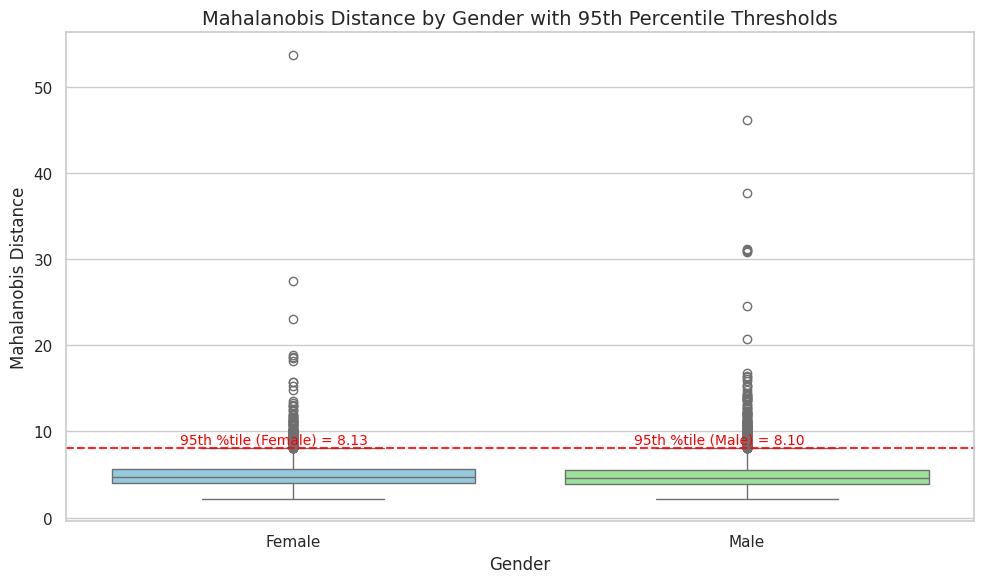

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use clean whitegrid style
sns.set(style="whitegrid")

# Convert gender to categorical label if you want clearer x-axis labels
df_outliers['Gender_label'] = df_outliers['Gender'].map({0.0: 'Female', 1.0: 'Male'})

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_outliers,
    x='Gender_label',
    y='mahalanobis_dist',
    hue='Gender_label',
    palette={'Female': 'skyblue', 'Male': 'lightgreen'},
    legend=False
)

# Add 95th percentile lines per gender
for gender_val, label in zip([0.0, 1.0], ['Female', 'Male']):
    threshold_95 = df_outliers[df_outliers['Gender'] == gender_val]['mahalanobis_dist'].quantile(0.95)
    plt.axhline(threshold_95, linestyle='--', color='red', alpha=0.6)
    plt.text(
        x=gender_val - 0.25,
        y=threshold_95 + 0.5,
        s=f"95th %tile ({label}) = {threshold_95:.2f}",
        color='red',
        fontsize=10
    )

# Labels
plt.title("Mahalanobis Distance by Gender with 95th Percentile Thresholds", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Mahalanobis Distance", fontsize=12)
plt.tight_layout()
plt.show()


### 6.2. PCA Projection
A PCA plot reduced the dataset to two principal components, showing how 95th percentile outliers were spatially separate from the main population cluster. This validated that Mahalanobis distance was effective in identifying unusual multivariate patterns.  
*Figure 2. PCA projection of patient features with 95th percentile Mahalanobis outliers highlighted in red.*

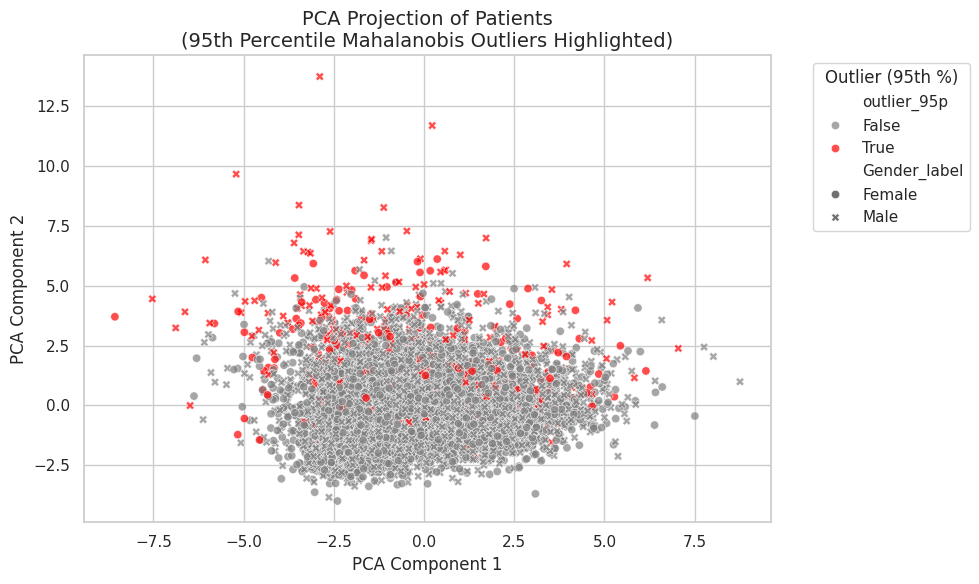

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select continuous features used in Mahalanobis
exclude_cols = ['Gender', 'In-hospital_death', 'mahalanobis_dist', 'outlier_95p', 'outlier_99p', 'Gender_label', 'PCA1', 'PCA2']
features = df_outliers.select_dtypes(include=['float64', 'int64']).columns.difference(exclude_cols)

# 2. Standardize before PCA
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_outliers[features])

# 3. Apply PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
df_outliers['PCA1'] = pca_components[:, 0]
df_outliers['PCA2'] = pca_components[:, 1]

# 4. Plot with better layout
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_outliers,
    x='PCA1',
    y='PCA2',
    hue='outlier_95p',
    style='Gender_label',
    palette={True: 'red', False: 'gray'},
    alpha=0.7
)
plt.title("PCA Projection of Patients\n(95th Percentile Mahalanobis Outliers Highlighted)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Outlier (95th %)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



### 6.3. Mortality Rate Comparison

In [ ]:
# Compare in-hospital death rate for 95th percentile outliers vs non-outliers
death_summary = df_outliers.groupby('outlier_95p')['In-hospital_death'].agg(['count', 'sum', 'mean'])
death_summary.columns = ['Total Patients', 'Deaths', 'Mortality Rate']

# Optional: Breakdown by gender too
gender_breakdown = df_outliers.groupby(['Gender_label', 'outlier_95p'])['In-hospital_death'].agg(['count', 'sum', 'mean'])
gender_breakdown.columns = ['Total Patients', 'Deaths', 'Mortality Rate']


<ipython-input-56-9811c797b2da>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_breakdown = df_outliers.groupby(['Gender_label', 'outlier_95p'])['In-hospital_death'].agg(['count', 'sum', 'mean'])


In [ ]:
print("🔎 Overall Comparison (95th Percentile Outliers vs Others):")
print(death_summary)

print("\n👩‍⚕️ By Gender:")
print(gender_breakdown)


🔎 Overall Comparison (95th Percentile Outliers vs Others):
             Total Patients  Deaths  Mortality Rate
outlier_95p                                        
False                  7490    1021        0.136315
True                    396     101        0.255051

👩‍⚕️ By Gender:
                          Total Patients  Deaths  Mortality Rate
Gender_label outlier_95p                                        
Female       False                  3269     475        0.145304
             True                    173      37        0.213873
Male         False                  4221     546        0.129353
             True                    223      64        0.286996


*Figure 3. Bar chart showing in-hospital death rate among outliers and non-outliers.*

<ipython-input-58-40122622b685>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_outliers, x='outlier_95p', y='In-hospital_death', ci=None)


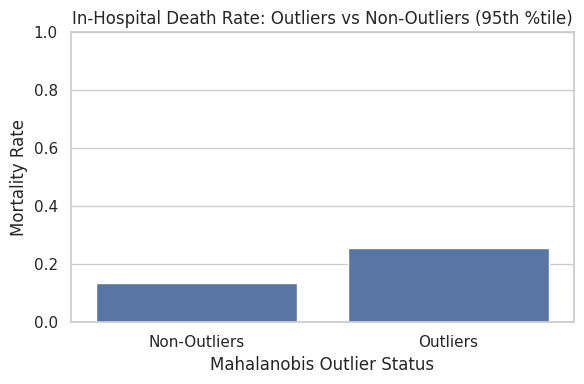

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(data=df_outliers, x='outlier_95p', y='In-hospital_death', ci=None)
plt.xticks([0, 1], ['Non-Outliers', 'Outliers'])
plt.title('In-Hospital Death Rate: Outliers vs Non-Outliers (95th %tile)')
plt.ylabel('Mortality Rate')
plt.xlabel('Mahalanobis Outlier Status')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


## 7. Conclusion
Stratified Mahalanobis distance is a powerful tool for outlier detection in healthcare datasets. By accounting for gender-specific distributions, we ensure fair and meaningful anomaly detection. Outliers flagged by this method show a higher risk of mortality, suggesting that Mahalanobis distance may aid in early risk identification.